implement neat in jax to beat internal AI in neural slime volleyball
- uses self-play to train the NN with evolution, then uses the NN to play against the internal AI

notebook for experiments

In [32]:
import jax
import jax.numpy as jnp
import numpy as np
import neat
import visualize
import os

from evojax.task.slimevolley import SlimeVolley

In [18]:
log_dir = "./logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# train_task = SlimeVolley(test=False, max_steps=3000, multiagent=True)
test_task = SlimeVolley(test=True, max_steps=3000)


In [10]:
screens = []

def play_match(net1, net2):
    """
    Play a match of SlimeVolley between two neural networks using the SlimeVolley class. Returns winner.
    """
    
    key = jax.random.PRNGKey(0)[None,:]
    task_reset_fn = jax.jit(train_task.reset)
    step_fn = jax.jit(train_task.step)
    # action_fn1 = jax.jit(net1.activate) # not jit compatible

    task_state = task_reset_fn(key) # initial task state

    while True:
        obs_left, obs_right = task_state.obs
        
        # action_left = action_fn1(obs_left.flatten())
        action_left = jnp.array(net1.activate(obs_left.flatten())) # NEAT-python expects flattened
        action_right = jnp.array(net2.activate(obs_right.flatten()))
        actions = jnp.stack((action_left, action_right), axis=0)

        actions = actions.reshape(1, 2, -1)

        task_state, reward, done = step_fn(task_state, actions)
        
        # show gif
        # img = SlimeVolley.render(task_state)
        # screens.append(img)

        if done:
            if task_state.game_state.agent_left.life > task_state.game_state.agent_right.life:
                return 1
            elif task_state.game_state.agent_left.life < task_state.game_state.agent_right.life:
                return -1
            else:
                return 0

In [11]:
n_rounds = 30

def fitness(genomes, config):
    """
    Gets the fitness of the genomes by playing a tournament of self-play matches.
    
    genomes: list of (id, genome)
    config: config object
    """

    nets = [neat.nn.FeedForwardNetwork.create(genome, config) for _, genome in genomes] # create nets from genome representation
    scores = [0] * len(genomes)

    # play tournament
    for match in range(1,n_rounds+1):
        i, j = np.random.choice(len(genomes), 2, replace=False) 
        # play match
        if match % 10 == 0:
            print(f"Playing match {i} vs {j}")
        winner = play_match(nets[i], nets[j]) 

        # generate gif
        # gif_filename = f"match_{i}_vs_{j}.gif"
        # screens[0].save(gif_filename, save_all=True, append_images=screens[1:], duration=40, loop=0)

        scores[i] += winner;
        scores[j] -= winner
 
    # update genome fitness from scores
    for i, score in enumerate(scores):
        genomes[i][1].fitness = score / len(scores) # normalize

In [33]:
# create config from file
config_file = "config-feedforward"
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_file)


# initialize starting population
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# winner = p.run(fitness, 20) # run NEAT with max generations

In [13]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [14]:
# def play_test(best_net):
#     task_reset_fn = jax.jit(test_task.reset)
#     step_fn = jax.jit(test_task.step)
#     key = jax.random.PRNGKey(0)[None, :]

#     task_state = task_reset_fn(key)
#     screens = []
#     for _ in range(3000):
#         action = jnp.array(best_net.activate(task_state.obs.flatten()))
#         # reshape action
#         action = action.reshape(1,-1)
#         task_state, reward, done = step_fn(task_state, action)
#         screens.append(SlimeVolley.render(task_state))

#     gif_file = os.path.join(log_dir, 'slimevolley.gif')
#     screens[0].save(gif_file, save_all=True, append_images=screens[1:],
#                     duration=40, loop=0)

In [34]:
def process_features(obs, direction):
    """
    Calculate engineered features for the agent, ensuring they are invariant to the side of the field the agent is on.
    
    obs: Observation from the environment.
    direction: Direction of the agent (-1 for left side, 1 for right side).
    Returns vector of features.
    """

    x,y,vx,vy,bx,by,bvx,bvy = obs
    
    # Calculate relative positions and velocities from the agent's perspective
    rel_ball_x = (bx - x) * direction
    rel_ball_y = by - y
    rel_ball_vx = bvx * direction
    rel_ball_vy = bvy
    
    return np.array([x,y,rel_ball_x, rel_ball_y, rel_ball_vx, rel_ball_vy])

In [49]:
def play_test(best_net, filename="slimevolley.gif"):
    """
    Play a match of SlimeVolley between the best neural network and in-built policy.
    Returns reward (indicating winner).
    """

    task_reset_fn = jax.jit(test_task.reset)
    step_fn = jax.jit(test_task.step)
    key = jax.random.PRNGKey(0)[None, :]

    task_state = task_reset_fn(key)
    screens = []
    for _ in range(999):
        obs = task_state.obs.flatten()[:8]
        processed_obs = process_features(obs, 1)
        action = jnp.array(best_net.activate(processed_obs))
        # reshape action
        action = action.reshape(1,-1)
        task_state, reward, done = step_fn(task_state, action)
        screens.append(SlimeVolley.render(task_state))


    gif_file = os.path.join(log_dir, filename)
    screens[0].save(gif_file, save_all=True, append_images=screens[1:],
                    duration=40, loop=0)

    return reward

In [46]:
def save_net(net, config, filename="best.npz"):
    # Extract weights and biases from the winner network
    weights_and_biases = {}
    for node, act_func, agg_func, bias, response, links in net.node_evals:
        weights_and_biases[node] = {
            "bias": bias,
            "response": response,
            "links": [(i, w) for i, w in links]
        }
    
    filepath = os.path.join(log_dir, filename)
    np.savez(filepath, config=config, weights_and_biases=weights_and_biases)


In [50]:
import pickle
# load from best.npz and play_test
log_dir = "../log/neat2024-03-28 01:53:55.080257"
# load a pickle
with open(os.path.join(log_dir, "best_450.pkl"), "rb") as f:
    winner = pickle.load(f)

best_net = neat.nn.FeedForwardNetwork.create(winner, config)
reward = play_test(best_net)

In [ ]:
# load all generations and play with inbuilt ai
for i in range(0,501,50):
    with open(os.path.join(log_dir, f"best_{i}.pkl"), "rb") as f:
        winner = pickle.load(f)
    best_net = neat.nn.feedforwardnetwork.create(winner, config)
    play_test(best_net, f"ai_vs_{i}.gif")

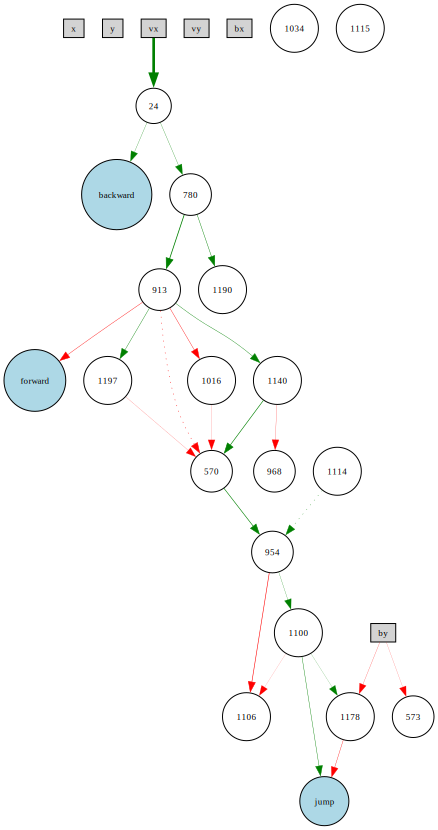

In [48]:
node_names = {0: "forward", 1: "backward", 2: "jump", -1: "x", -2: "y", -3: "vx", -4: "vy", -5: "bx", -6: "by", -7: "bvx", -8: "bvy", -9: "ox", -10: "oy", -11: "ovx", -12: "ovy"}  
visualize.draw_net(config, winner, True, node_names=node_names)


In [42]:
# load in stats
with open(os.path.join(log_dir, "stats_500.pkl"), "rb") as f:
    stats = pickle.load(f)

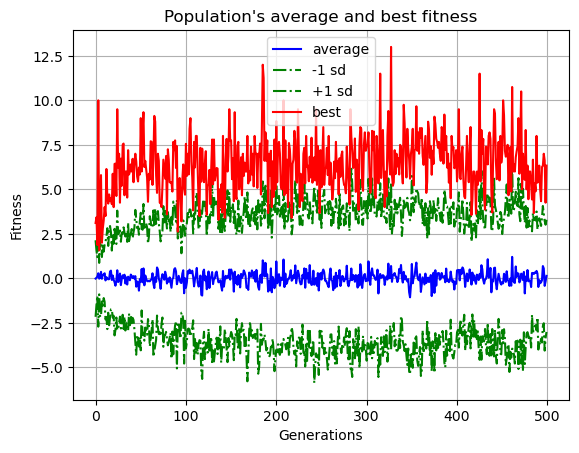

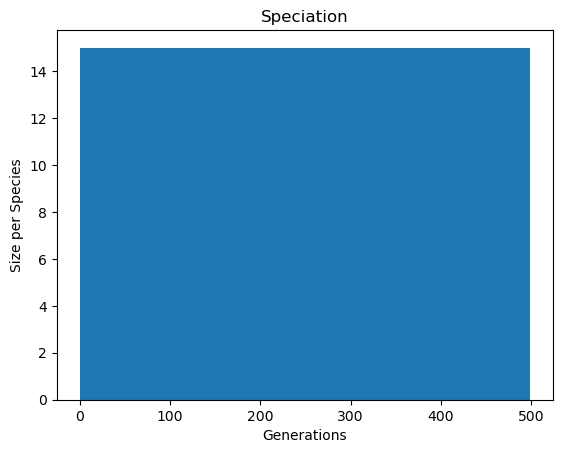

In [43]:
# visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)